In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('Sunspots.csv',index_col='Date',parse_dates=True) #C:\Users\deeks\OneDrive\Desktop\PROJECT\
df.index.freqs='MS' 

In [3]:
display(df)

,Unnamed: 0,Monthly Mean Total Sunspot Number
Date,,
1749-01-31,0,96.7
1749-02-28,1,104.3
1749-03-31,2,116.7
1749-04-30,3,92.8
1749-05-31,4,141.7
...,...,...
2020-09-30,3260,0.6
2020-10-31,3261,14.4
2020-11-30,3262,34.0


In [4]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
    X,y =[],[]
    for i in range(len(timeseries_data)):
        #find the end of this pattern
        end_ix = i + n_features
        #check if we are beyond the sequence
        if end_ix > len(timeseries_data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
            

Processing the data

In [5]:
import csv

# Processing and preparing the data
time_step = []
sunspots = []

with open('Sunspots.csv') as csvfile:  
    reader = csv.reader(csvfile, delimiter=',')  #C:\Users\deeks\OneDrive\Desktop\PROJECT\
    next(reader) # the next() function skips the first line (header) when looping
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

In [6]:
# For plotting the series or data
def plot_series(time, series, format="-", start=0, end=None, label=None):
    myplot = plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time (Months)")
    plt.ylabel("Average Monthly Sunpots")
    if label != None:
        plt.legend()
    plt.grid(True)

Before plotting, the data gets converted to Numpy arrays

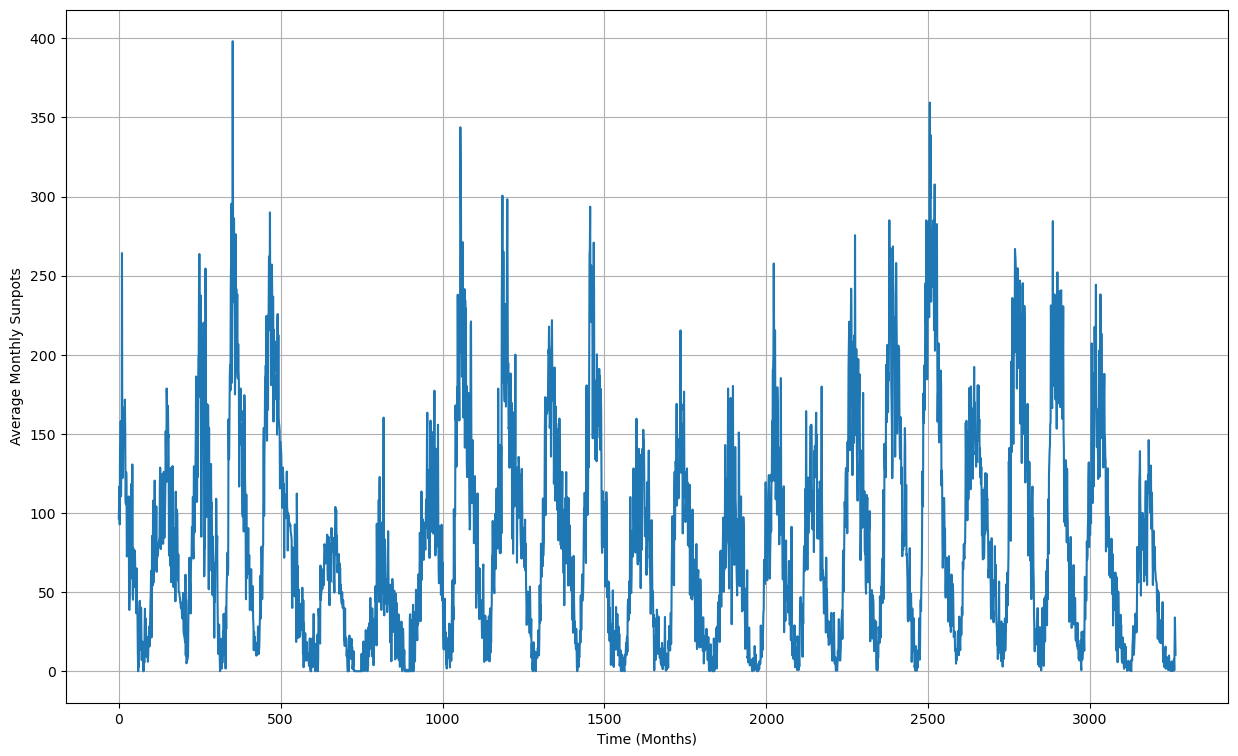

In [7]:
series = np.array(sunspots)
time = np.array(time_step)
#Looking at the data
plt.figure(figsize=(15, 9))
plot_series(time, series)

Pre-Processing

In [8]:
# Adjusting the parameters & preparing the Model
split_time = 3000
window_size= 30
batch_size = 32
shuffle_buffer_zone = 1000

# Training data
#Splitting Training Data into Test and Validation Sets
train_time = time[:split_time]
X_train = series[:split_time]
# Validation data
valid_time = time[split_time:]
X_valid = series[split_time:]
     

Splitting the data Graphing help us understanding the split better

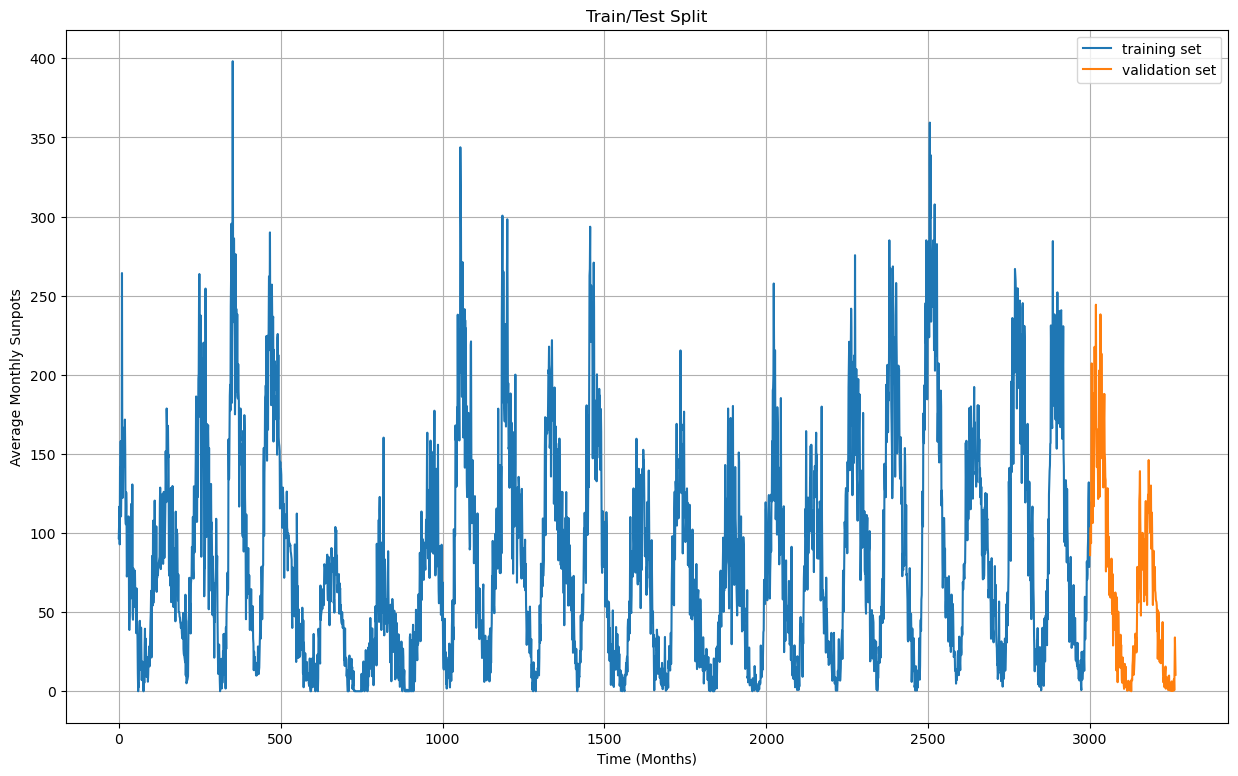

In [9]:
plt.figure(figsize=(15, 9))
plt.title("Train/Test Split")
plot_series(train_time, X_train, label="training set")
plot_series(valid_time, X_valid, label="validation set")

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

To demonstrate how the windowed_dataset function and the window_size parameter are slicing the data set, have a closer look at the graph below.

In [11]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [19]:
import tensorflow as tf

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
shuffle_buffer_zone = 1000
train_set = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_zone)
print(train_set)
print(X_train.shape)


# Define the CNN-LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Compile the model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
              metrics=["mae"])

# Fit the model
history = model.fit(train_set, epochs=60)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(3000,)


D:\Anaconda3-2024.02-1-Windows\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - loss: 101.4017 - mae: 101.8999
Epoch 2/60


D:\Anaconda3-2024.02-1-Windows\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 100.6130 - mae: 101.1111
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 99.9757 - mae: 100.4736
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 99.5119 - mae: 100.0100
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 97.2360 - mae: 97.7341
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 95.9807 - mae: 96.4789
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - loss: 95.2341 - mae: 95.7324
Epoch 8/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 94.7462 - mae: 95.2447
Epoch 9/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 93.5706 - mae: 94.0691
Epoch 10/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 92.6153 - mae: 93.1140
Epoch 11/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 93.2238 - mae: 93.7223
Epoch 12/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 90.5637 - mae: 91.0623
Epoch 13/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 90.5797 - mae: 91.0782
Epoch 1

101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
First 10 Predictions : 
 [146.45694 154.14848 167.88145 147.93988 148.04729 157.53674 161.02583
 179.30078 179.89932 166.71222]

MAE: 21.22188583592199


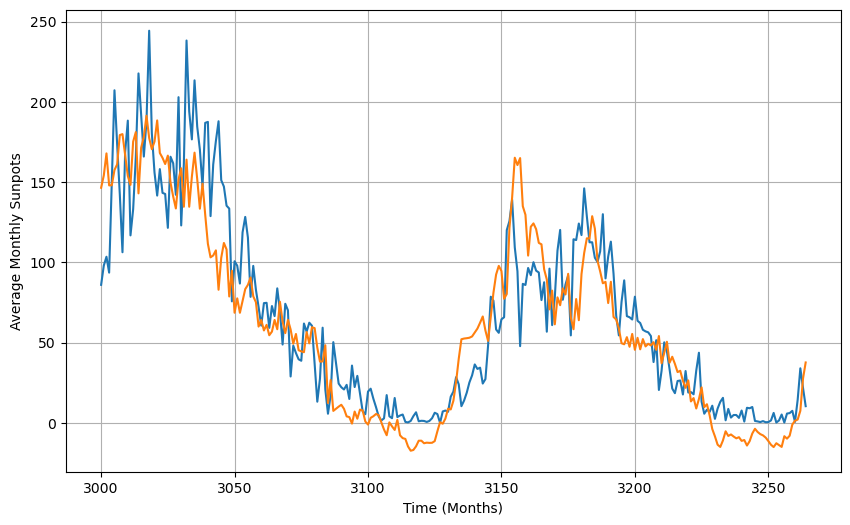

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
print("First 10 Predictions :","\n", rnn_forecast[:10])
print('')

mae = tf.reduce_mean(tf.abs(X_valid - rnn_forecast)).numpy()
print("MAE:", mae)

plt.figure(figsize=(10, 6))
plot_series(valid_time, X_valid)
plot_series(valid_time, rnn_forecast)

Forecasting and Evaluating Here, we see the last sun-spot cycle and how the model (orange) at least visually matches the training/validation (blue) data quite well.

In [15]:
for i in range(10,20):
    print(X_valid[i], " - ", rnn_forecast[i])

188.3  -  153.80011
116.8  -  148.25342
133.1  -  175.21236
165.7  -  181.1399
217.7  -  142.97058
191.5  -  171.38503
165.9  -  178.3229
188.0  -  191.3408
244.3  -  177.4986
180.5  -  170.50514


In [16]:
print(X_valid.shape)
print(rnn_forecast.shape)

from sklearn.metrics import mean_squared_error
from math import sqrt
mse=mean_squared_error(X_valid,rnn_forecast)
print("mse = ", mse)
rmse=sqrt(mse)
print("rmse = ", rmse)

(265,)
(265,)
mse =  789.5144947424681
rmse =  28.09830056680418


In [17]:
# Define the number of future time steps to forecast
future_steps = 100

# Function to generate forecasts
def generate_forecasts(model, series, window_size, future_steps):
    # Create a copy of the series to hold the forecasted values
    forecast_series = series.copy()
    
    # Iterate over the number of future steps to forecast
    for step in range(future_steps):
        # Extract the most recent window from the series
        recent_window = forecast_series[-window_size:]
        
        # Reshape the window to match the input shape expected by the model
        recent_window = recent_window.reshape(1, -1, 1)
        
        # Predict the next value using the model
        next_value = model.predict(recent_window)[0, -1, 0]
        
        # Append the predicted value to the forecast series
        forecast_series = np.append(forecast_series, next_value)
    
    return forecast_series

# Generate forecasts using the trained model and the training set
train_forecasts = generate_forecasts(model, X_train, window_size, future_steps)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━

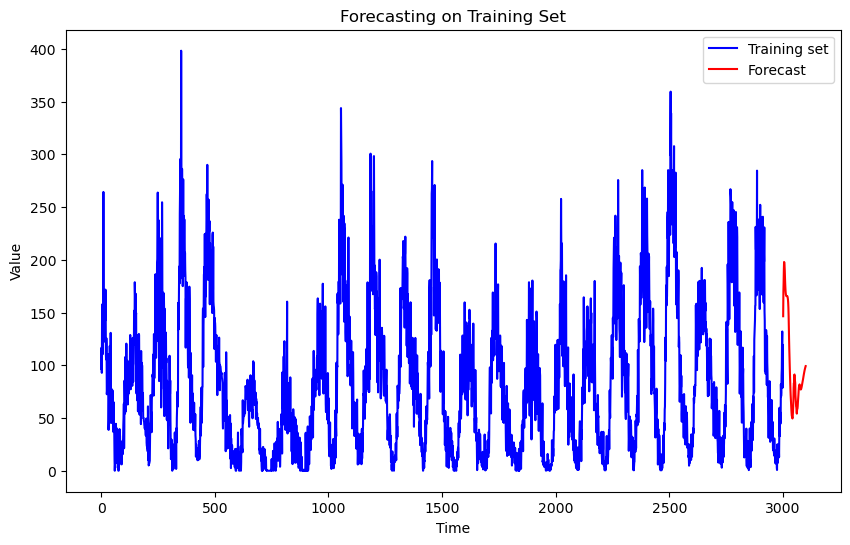

In [18]:
# Plot the original series and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(time[:len(X_train)], X_train, label='Training set', color='blue')
plt.plot(time[len(X_train):len(X_train)+future_steps], train_forecasts[-future_steps:], label='Forecast', color='red')
plt.title('Forecasting on Training Set')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()